In [1]:
################################################
# intialize word enumeration
################################################

# config
INCLUDE_BIGRAMS = False

# definitions
PADDING = 0
UNKNOWN_WORD = 1
ENUMERATION_BEGIN = 2

# coverts this string to: ['converts', 'this', 'string', 'to', 'converts this', 'this string', 'string to']
def add_bigrams_to_tweet(tweet):
    # collect bigrams
    bigrams = list()
    prev = None
    for word in tweet:
        if prev is not None: bigrams.append(prev + " " + word)
        prev = word
    # append bigrams
    for bigram in bigrams:
        tweet.append(bigram)
    # return, but this is the same list we passed in
    return tweet


def enumerate_words(tweets):
    # enumerate all words (bigram or otherwise)
    corpus = set()
    for tweet in tweets:
        for word in tweet:
            corpus.add(word)
    # save in dictionary
    w2i = dict()
    i = ENUMERATION_BEGIN
    for word in list(corpus):
        w2i[word] = i
        i += 1
    # return dict
    return w2i


def get_word_vector(w2i, tweet, enforce_length=None):
    # prep
    vec = list()
    i = 0
    # convert words to integers
    for w in tweet:
        if w in w2i: vec.append(w2i[w])
        else: vec.append(UNKNOWN_WORD)
        i += 1
        # stop at enforce_length (if set)
        if enforce_length is not None and i + 1 == enforce_length:
            break
    # pad
    if enforce_length is not None:
        while i < enforce_length:
            vec.append(PADDING)
            i += 1   
    # fin
    return vec
        
    
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# if bigram:
#     vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\\b\\w+\\b',
#                                  min_df=1, decode_error='ignore', stop_words=stop_words,
#                                  lowercase=lowercase)
#     vectorizer = CountVectorizer(decode_error='ignore', stop_words=stop_words, lowercase=lowercase)\n",

In [2]:
################################################
# file parsing functions
################################################
from nltk.tokenize import TweetTokenizer
import string, re
import collections
import numpy as np
import glove
from glove.glove_cython import fit_vectors, transform_paragraph

# definitions
HC="HillaryClinton"
DT="realDonaldTrump"
NA="none"
HANDLES = [HC,DT,NA]
HANDLE_MAP = {NA:-1, HC:0, DT:1}

# read csv file, return handles and tweets
def parse_tweet_csv(file, file_encoding="utf8"):
    # init
    handles, tweets = [], []
    
    # read file
    linenr = -1
    with open(file, encoding=file_encoding) as input:
        try:
            for line in input:
                linenr += 1
                if linenr == 0: continue
                
                # get contents
                line = line.split(",")
                if line[0] in HANDLES: #label and irst line of tweet
                    handles.append(line[0])
                    tweet = ','.join(line[1:])
                    tweets.append(tweet)
                else: #second+ line of tweet
                    tweet = tweets.pop()
                    tweet += ','.join(line)
                    tweets.append(tweet)
        except Exception as e:
            print("Exception at line {}: {}".format(linenr, e))
            raise e
    
    # sanity checks
    assert len(handles) == len(tweets)
    print("Found {} tweets in {} lines".format(len(tweets), linenr + 1))
    
    # return data
    return handles, tweets


##########################################
### coverting tweet strings to numbers ###

# coverting labels to integers
def int_labels(labels):
    return list(map(lambda x: HANDLE_MAP[x], labels))

#tokenizing
_tokenizer = TweetTokenizer()
_punctuation = set(string.punctuation)
def tokenize(tweet, lowercase=True, strip_urls=True, strip_punctuation=True):
    tokens = _tokenizer.tokenize(tweet)
    if lowercase: tokens = list(map(lambda x: x.lower(), tokens))
    if strip_urls: tokens = list(filter(lambda x: not x.startswith("http"), tokens))
    if strip_punctuation: #https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string-in-python
        tokens = list(filter(lambda x: x.startswith(u'@') or x.startswith(u'#') or x not in _punctuation and not re.match(u"[^\w\d'\s$]+", x), tokens))
    return tokens

# get all tweets
def import_text(tweets):
    tokenized_tweets = [tokenize(tweet) for tweet in tweets]
    if INCLUDE_BIGRAMS:
        for tweet in tokenized_tweets:
            add_bigrams_to_tweet(tweet)
    w2i = enumerate_words(tokenized_tweets)
    return [get_word_vector(w2i, tweet, enforce_length=50) for tweet in tokenized_tweets], tokenized_tweets, w2i

In [3]:
################################################
# get raw test data
################################################
import random

# init
TEST_RATIO = 0.1
assert TEST_RATIO > 0 and TEST_RATIO < 1

# get data
text_handles, raw_tweets = parse_tweet_csv("train.csv")
handles = int_labels(text_handles)
tweets, tokenized_tweets, word_mapping = import_text(raw_tweets)   
data_vector_size = len(tweets[0])

### validation
for i in range(1):
    rand_i = random.randint(0, len(raw_tweets))
    print()
    print(raw_tweets[i].strip())
    print(tokenized_tweets[i])
    print(tweets[i])
    print(handles[i])
    print()

Found 4743 tweets in 6251 lines

The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG
['the', 'question', 'in', 'this', 'election', 'who', 'can', 'put', 'the', 'plans', 'into', 'action', 'that', 'will', 'make', 'your', 'life', 'better']
[6205, 1260, 6973, 3470, 5228, 6486, 1561, 4059, 6205, 4799, 4669, 6197, 901, 3193, 6351, 2951, 1598, 2850, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0



In [4]:
################################################
# split test data into train and test
################################################
import pandas as pd

LABEL = 'handle'
DATA = 'tweet_data'
LENGTH = 'length'

VOCAB_SIZE = len(word_mapping) + ENUMERATION_BEGIN

# split into test and train
train_labels, train_data, test_labels, test_data = list(), list(), list(), list()
for handle, tweet in zip(handles, tweets):
    if random.random() < TEST_RATIO:
        test_labels.append(handle)
        test_data.append(tweet)
    else:
        train_labels.append(handle)
        train_data.append(tweet)

# document and validate
print("Separated into {} train and {} test ({}%)\n".format(len(train_data), len(test_data), 
                                                         int(100.0 * len(test_data) / len(raw_tweets))))
assert len(train_labels) == len(train_data) and len(train_data) > 0
assert len(test_labels) == len(test_data) and len(test_data) > 0
assert len(test_labels) > len(tweets) * (TEST_RATIO - .05)
assert len(test_labels) < len(tweets) * (TEST_RATIO + .05) 

# save to dataframe
train = pd.DataFrame({
    LABEL: train_labels,
    DATA: train_data,
    LENGTH: [data_vector_size for _ in range(len(train_data))]
})
test = pd.DataFrame({
    LABEL: test_labels,
    DATA: test_data,
    LENGTH: [data_vector_size for _ in range(len(test_data))]
})
print(train.head())

Separated into 4251 train and 492 test (10%)

   handle  length                                         tweet_data
0       0      50  [6205, 1260, 6973, 3470, 5228, 6486, 1561, 405...
1       0      50  [575, 7959, 7954, 4374, 5501, 177, 4904, 5882,...
2       0      50  [4785, 4460, 112, 2603, 4014, 2423, 5996, 2290...
3       1      50  [6490, 3403, 683, 4914, 5717, 7838, 3399, 6561...
4       0      50  [1540, 7954, 4374, 7236, 6593, 1708, 7991, 676...


In [5]:
################################################
# initializing our tensor
#
# based off of blogpost david parks showed us:
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html
################################################
import tensorflow as tf
 
class DataIterator():
    def __init__(self, df):
        self.df = df
        self.size = len(self.df)
        self.epochs = 0
        self.shuffle()

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        self.cursor = 0

    def next_batch(self, n):
        if self.cursor + n - 1 > self.size:
            self.epochs += 1
            self.shuffle()
        res = self.df.ix[self.cursor:self.cursor + n - 1]
        start_idx = self.cursor
        self.cursor += n
        # return res[DATA], res[LABEL], res[LENGTH]
        # the above line fails.  an error is thrown when tf attempts to call np.asarray on this.
        # what is different about how our data is organized compared to the blog post this came from?
        # TODO 
        data = res[DATA]
        labels = res[LABEL]
        length = res[LENGTH]
        return np.asarray([data[i] for i in range(start_idx, start_idx + len(data))]), \
               np.asarray([labels[i] for i in range(start_idx, start_idx + len(labels))]), \
               np.asarray([length[i] for i in range(start_idx, start_idx + len(length))])

# validate data iterator
d = DataIterator(test).next_batch(2)
print('Input sequences:\n', 
      "{}: \n{}\n".format(type(d[0]), d[0]), 
      "{}: \n{}\n".format(type(d[0][0]), d[0][0]), 
      "{}: \n{}\n".format(type(d[0][0][0]), d[0][0][0]), 
      end='\n\n')
print('Target values\n', 
      "{}: \n{}\n".format(type(d[1]), d[1]), 
      "{}: \n{}\n".format(type(d[1][0]), d[1][0]), 
      end='\n\n')
print('Sequence lengths\n', 
      "{}: \n{}\n".format(type(d[2]), d[2]), 
      "{}: \n{}\n".format(type(d[2][0]), d[2][0]), 
      end='\n\n')

Input sequences:
 <class 'numpy.ndarray'>: 
[[1368 7441 2203 4090 1415 5844 1189  420 6205 6522  824 4977  901 3193
  4059 7441 1261 2203 6381 1411 1640    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [4116 5321 4914  134 3198 4014 3403 2451 5992 8320  758 4914 2236 3685
   253 6549 1504 2360 6853 5992  593 7285 6787  814 5526    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
 <class 'numpy.ndarray'>: 
[1368 7441 2203 4090 1415 5844 1189  420 6205 6522  824 4977  901 3193 4059
 7441 1261 2203 6381 1411 1640    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
 <class 'numpy.int32'>: 
1368


Target values
 <class 'numpy.ndarray'>: 
[1 1]
 <class 'numpy.int64'>: 
1


Sequence lengths
 <class 'numpy.ndarray'>: 
[50

In [6]:
################################################
# initializing our tensor
#
# based off of blogpost david parks showed us:
# https://r2rt.com/recurrent-neural-networks-in-tensorflow-iii-variable-length-sequences.html
################################################
import tensorflow as tf

# this is a global variable we use to graph results.  it should be reset to 'list()' before running
PLOTTING_INFO = None

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()


def build_graph(vocab_size = VOCAB_SIZE, state_size = 64, batch_size = 256, num_classes = 2):

    reset_graph()

    # Placeholders
    x = tf.placeholder(tf.int32, [batch_size, None]) # [batch_size, num_steps]
    seqlen = tf.placeholder(tf.int32, [batch_size])
    y = tf.placeholder(tf.int32, [batch_size])
    keep_prob = tf.placeholder_with_default(1.0, [])

    # Embedding layer
    embeddings = tf.get_variable('embedding_matrix', [vocab_size, state_size])
    rnn_inputs = tf.nn.embedding_lookup(embeddings, x)

    # RNN
    cell = tf.nn.rnn_cell.GRUCell(state_size)
    init_state = tf.get_variable('init_state', [1, state_size],
                                 initializer=tf.constant_initializer(0.0))
    init_state = tf.tile(init_state, [batch_size, 1])
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, sequence_length=seqlen,
                                                 initial_state=init_state)

    # Add dropout, as the model otherwise quickly overfits
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)
    idx = tf.range(batch_size)*tf.shape(rnn_outputs)[1] + (seqlen - 1)
    # last_rnn_output = tf.gather(tf.reshape(rnn_outputs, [-1, state_size]), idx)
    # last_rnn_output = tf.gather_nd(rnn_outputs, tf.pack([tf.range(batch_size), seqlen-1], axis=1))
    last_rnn_output = tf.gather_nd(rnn_outputs, tf.stack([tf.range(batch_size), seqlen-1], axis=1))

    # Softmax layer
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W', [state_size, num_classes]) # weights?
        b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0)) # bias?
    logits = tf.matmul(last_rnn_output, W) + b
    preds = tf.nn.softmax(logits)
    correct = tf.equal(tf.cast(tf.argmax(preds,1),tf.int32), y)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

    return {
        'x': x,
        'seqlen': seqlen,
        'y': y,
        'dropout': keep_prob,
        'loss': loss,
        'ts': train_step,
        'preds': preds,
        'accuracy': accuracy
    }


def train_graph(g, batch_size = 256, num_epochs = 10, iterator = DataIterator):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tr = iterator(train)
        te = iterator(test)

        step, accuracy = 0, 0
        tr_losses, te_losses = [], []
        current_epoch = 0
        while current_epoch < num_epochs:
            step += 1
            batch = tr.next_batch(batch_size)
            feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2], g['dropout']: 0.6}
            accuracy_, _ = sess.run([g['accuracy'], g['ts']], feed_dict=feed)
            accuracy += accuracy_

            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_losses.append(accuracy / step)
                step, accuracy = 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    batch = te.next_batch(batch_size)
                    feed = {g['x']: batch[0], g['y']: batch[1], g['seqlen']: batch[2]}
                    accuracy_ = sess.run([g['accuracy']], feed_dict=feed)[0]
                    accuracy += accuracy_

                te_losses.append(accuracy / step)
                step, accuracy = 0,0
                print("Accuracy after epoch", current_epoch, " - tr:", tr_losses[-1], "- te:", te_losses[-1])

    return tr_losses, te_losses

In [10]:
################################################
# run it!
################################################

# this fails, just like us
g = build_graph()
tr_losses, te_losses = train_graph(g, num_epochs=32)


Accuracy after epoch 1  - tr: 0.487821691176 - te: 0.513671875
Accuracy after epoch 2  - tr: 0.50390625 - te: 0.53515625
Accuracy after epoch 3  - tr: 0.4912109375 - te: 0.50390625
Accuracy after epoch 4  - tr: 0.507568359375 - te: 0.4921875
Accuracy after epoch 5  - tr: 0.512451171875 - te: 0.52734375
Accuracy after epoch 6  - tr: 0.57373046875 - te: 0.81640625
Accuracy after epoch 7  - tr: 0.66943359375 - te: 0.83203125
Accuracy after epoch 8  - tr: 0.87841796875 - te: 0.87109375
Accuracy after epoch 9  - tr: 0.9208984375 - te: 0.87890625
Accuracy after epoch 10  - tr: 0.928955078125 - te: 0.88671875
Accuracy after epoch 11  - tr: 0.947265625 - te: 0.90625
Accuracy after epoch 12  - tr: 0.963134765625 - te: 0.9296875
Accuracy after epoch 13  - tr: 0.97509765625 - te: 0.90625
Accuracy after epoch 14  - tr: 0.980712890625 - te: 0.92578125
Accuracy after epoch 15  - tr: 0.986328125 - te: 0.9296875
Accuracy after epoch 16  - tr: 0.9892578125 - te: 0.90625
Accuracy after epoch 17  - tr: 0

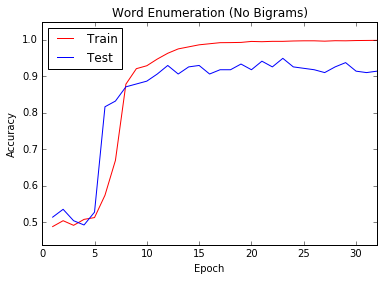

In [11]:
################################################
# plot it!
################################################

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

title = "Word Enumeration"
title += " (Bigrams)" if INCLUDE_BIGRAMS else " (No Bigrams)"

x_coords = [i+1 for i in range(len(tr_losses))]
tr_line, = plt.plot(x_coords, tr_losses, 'r-', label="Train")
te_line, = plt.plot(x_coords, te_losses, 'b-', label="Test")
plt.axis([0, len(tr_losses), min(min(tr_losses), min(te_losses)) - .05, 1.05])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(title)
plt.legend(handles=[tr_line, te_line], loc=2)
plt.show()

In [9]:
#TODO: we're overfitting, why?

#TODO: try something better than averaging the word vec values
# maybe we could do three-d arrays?  encode each word and pad the data

#TODO: we strip a lot away (ie punctuation, smilies) and lose other
# data to glove (#hashtags, @handles). how can we keep this?

#TODO: how do we run this on the test dataset?



##############################################################################
"""
What we tried:

glove library - broke even
    overfit and data was varied
glove "average tweet value"
    overfit and test data was varied
glove ATV with variance 
    this worked worse than ATV
twitter glove worked worse (but need better tokenizing)

"""

'\nWhat we tried:\n\nglove library - broke even\n    overfit and data was varied\nglove "average tweet value"\n    overfit and test data was varied\nglove ATV with variance \n    this worked worse than ATV\ntwitter glove worked worse (but need better tokenizing)\n\n'